In [1]:
import sys
from typing import List, Mapping, Optional, Union

import torch
import numpy as np
import pandas as pd
import scanpy as sc
import faiss
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
from anndata import AnnData

import STAGATE_pyG

/rd2/user/xiacr/spatialGLUE/env/stagate/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def spatial_match(embds:List[torch.Tensor],
                  reorder:Optional[bool]=True,
                  top_n:Optional[int]=20,
                  smooth:Optional[bool]=True,
                  smooth_range:Optional[int]=20,
                  scale_coord:Optional[bool]=True,
                  adatas:Optional[List[AnnData]]=None,
                  verbose:Optional[bool]=False
    )-> List[Union[np.ndarray,torch.Tensor]]:
    r"""
    Use embedding to match cells from different datasets based on cosine similarity
    
    Parameters
    ----------
    embds
        list of embeddings
    reorder
        if reorder embedding by cell numbers
    top_n
        return top n of cosine similarity
    smooth
        if smooth the mapping by Euclid distance
    smooth_range
        use how many candidates to do smooth
    scale_coord
        if scale the coordinate to [0,1]
    adatas
        list of adata object
    verbose
        if print log
    
    Note
    ----------
    Automatically use larger dataset as source
    
    Return
    ----------
    Best matching, Top n matching and cosine similarity matrix of top n  
    
    Note
    ----------
    Use faiss to accelerate, refer https://github.com/facebookresearch/faiss/issues/95
    """
    if reorder and embds[0].shape[0] < embds[1].shape[0]:
        embd0 = embds[1]
        embd1 = embds[0]
        adatas = adatas[::-1] if adatas is not None else None
    else:
        embd0 = embds[0]
        embd1 = embds[1]
    index = faiss.index_factory(embd1.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
    embd0_np = embd0.detach().cpu().numpy() if torch.is_tensor(embd0) else embd0
    embd1_np = embd1.detach().cpu().numpy() if torch.is_tensor(embd1) else embd1
    embd0_np = embd0_np.copy().astype('float32')
    embd1_np = embd1_np.copy().astype('float32')
    faiss.normalize_L2(embd0_np)
    faiss.normalize_L2(embd1_np)
    index.add(embd0_np)
    distance, order = index.search(embd1_np, top_n)
    best = []
    if smooth and adatas != None:
        smooth_range = min(smooth_range, top_n)
        if verbose:
            print('Smoothing mapping, make sure object is in same direction')
        if scale_coord:
            # scale spatial coordinate of every adata to [0,1]
            adata1_coord = adatas[0].obsm['spatial'].copy()
            adata2_coord = adatas[1].obsm['spatial'].copy()
            for i in range(2):
                    adata1_coord[:,i] = (adata1_coord[:,i]-np.min(adata1_coord[:,i]))/(np.max(adata1_coord[:,i])-np.min(adata1_coord[:,i]))
                    adata2_coord[:,i] = (adata2_coord[:,i]-np.min(adata2_coord[:,i]))/(np.max(adata2_coord[:,i])-np.min(adata2_coord[:,i]))
        for query in range(embd1_np.shape[0]):
            ref_list = order[query, :smooth_range]
            dis = euclidean_distances(adata2_coord[query,:].reshape(1, -1), 
                                      adata1_coord[ref_list,:])
            best.append(ref_list[np.argmin(dis)])
    else:
        best = order[:,0]
    return np.array(best), order, distance


In [3]:
sys.path.append("../../../scSLAT/viz")
from multi_dataset import match_3D_celltype, match_3D_multi

In [4]:
adata1 = sc.read_h5ad('../seqFISH_filer.h5ad')
adata2 = sc.read_h5ad('../Stereo_filer.h5ad')
adata1.obs['dataset'] = 'dataset1'
adata2.obs['dataset'] = 'dataset2'

In [5]:
STAGATE_pyG.Cal_Spatial_Net(adata1, k_cutoff=20, model='KNN')
STAGATE_pyG.Cal_Spatial_Net(adata2, k_cutoff=20, model='KNN')
adata = sc.concat([adata1, adata2])
adata.uns['Spatial_Net'] = pd.concat([adata1.uns['Spatial_Net'], adata2.uns['Spatial_Net']])

------Calculating spatial graph...
The graph contains 230580 edges, 11529 cells.
20.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 100620 edges, 5031 cells.
20.0000 neighbors per cell on average.


# Run STAGATE

In [6]:
adata = STAGATE_pyG.train_STAGATE(adata, device='cuda:4')

Size of Input:  (16560, 347)


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.39it/s]


In [7]:
embd0 = adata[adata.obs['dataset']=='dataset1'].obsm['STAGATE']
embd1 = adata[adata.obs['dataset']=='dataset2'].obsm['STAGATE']

In [8]:
best, index, distance = spatial_match([embd1, embd0], reorder=True)
matching = np.array([range(index.shape[0]), best])

In [13]:
adata1_df = pd.DataFrame({'index':range(adata1.shape[0]),
                          'x': adata1.obsm['spatial'][:,0],
                          'y': adata1.obsm['spatial'][:,1],
                          'celltype':adata1.obs['celltype_mapped_refined']})
adata2_df = pd.DataFrame({'index':range(adata2.shape[0]),
                          'x': adata2.obsm['spatial'][:,0],
                          'y': adata2.obsm['spatial'][:,1],
                          'celltype':adata2.obs['annotation']})
matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

/rd2/user/xiacr/SLAT/case/spatial_cross_platform/other_methods/../../../scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Definitive endoderm', 'Cardiomyocytes', 'Cranial mesoderm', 'Erythroid', 'Lateral plate mesoderm', 'Endothelium', 'Haematoendothelial progenitors', 'Allantois', 'Splanchnic mesoderm', 'Intermediate mesoderm', 'NMP', 'ExE endoderm', 'Anterior somitic tissues', 'Mixed mesenchymal mesoderm', 'Surface ectoderm', 'Presomitic mesoderm', 'Blood progenitors', 'Forebrain/Midbrain/Hindbrain', 'AGM', 'Heart', 'Liver', 'Mesenchyme', 'Connective tissue', 'Branchial arch', 'Notochord', 'Brain']]
Subsample 300 cell pairs from 5031


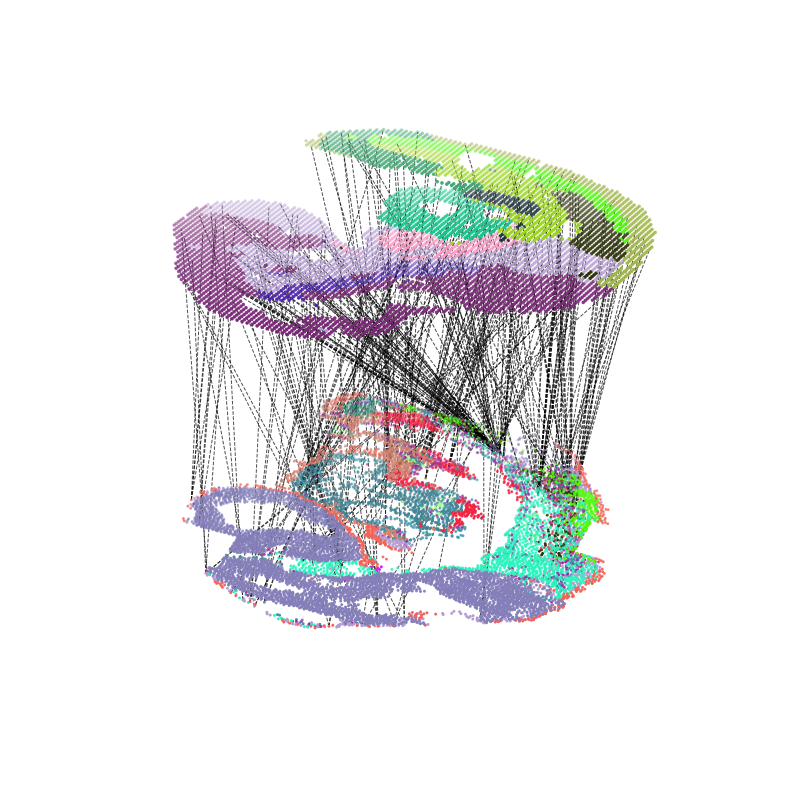

In [17]:
multi_align = match_3D_multi(adata1_df, adata2_df, matching, meta='celltype',
                             scale_coordinate=True, subsample_size=300, exchange_xy=False)

multi_align.draw_3D(size=[10, 12], line_width=0.7, line_color='black', point_size=[1.25,2.5], 
                    hide_axis=True, show_error=False)

/rd2/user/xiacr/SLAT/case/spatial_cross_platform/other_methods/../../../scSLAT/viz/multi_dataset.py:204: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.celltypes = set(self.dataset_A[meta].append(self.dataset_B[meta]))


dataset1: 21 cell types; dataset2: 11 cell types; 
                    Total :29 celltypes; Overlap: 3 cell types 
                    Not overlap :[['Definitive endoderm', 'Cardiomyocytes', 'Cranial mesoderm', 'Erythroid', 'Lateral plate mesoderm', 'Endothelium', 'Haematoendothelial progenitors', 'Allantois', 'Splanchnic mesoderm', 'Intermediate mesoderm', 'NMP', 'ExE endoderm', 'Anterior somitic tissues', 'Mixed mesenchymal mesoderm', 'Surface ectoderm', 'Presomitic mesoderm', 'Blood progenitors', 'Forebrain/Midbrain/Hindbrain', 'AGM', 'Heart', 'Liver', 'Mesenchyme', 'Connective tissue', 'Branchial arch', 'Notochord', 'Brain']]
Subsample 500 cell pairs from 5031


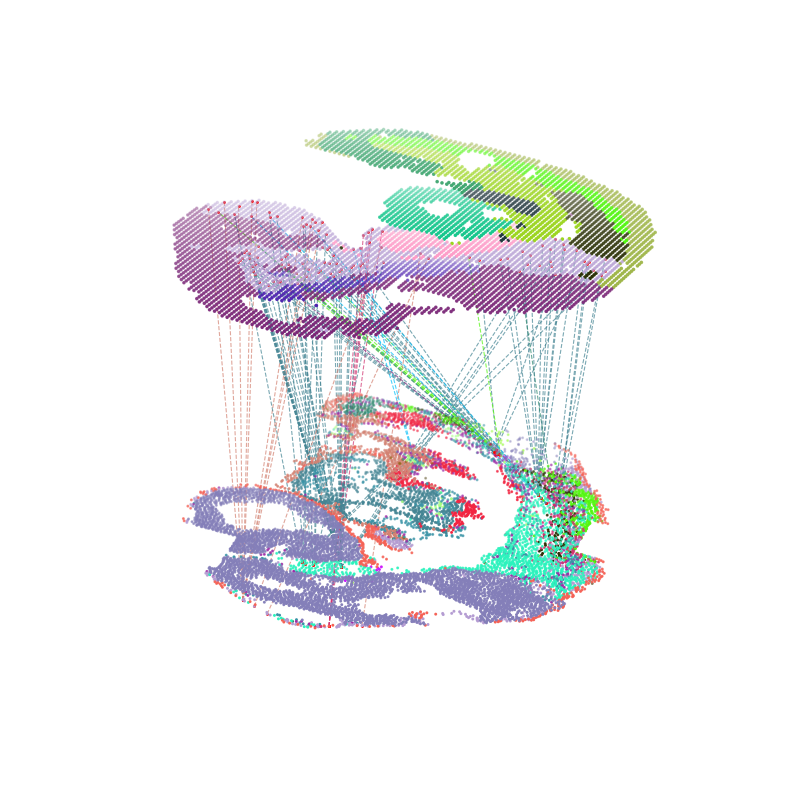

In [19]:
test = match_3D_celltype(adata1_df, adata2_df, matching, meta='celltype', highlight_celltype=[list(set(adata1_df.celltype)),['Neural crest']],
                         subsample_size=500, highlight_cell=['red'], scale_coordinate=True)
test.draw_3D(size=[10, 12], line_width=0.8, point_size=[1.25,2.5], hide_axis=True)